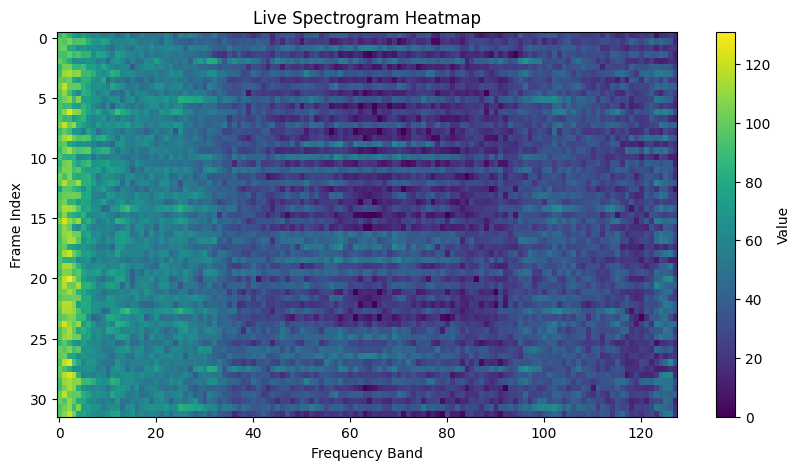

In [ ]:
from IPython import display
#matplotlib inline   # enable inline plotting in Jupyter

import serial
import matplotlib.pyplot as plt
import numpy as np
import time

def read_serial_data(serial_port, baud_rate=921600):
    try:
        ser = serial.Serial(serial_port, baud_rate, timeout=2)
    except Exception as e:
        print(f"Serial error: {e}")
        return

    while True:
        line = ser.readline().decode('utf-8', errors='ignore').strip()
        if "Spectrogram (128 bands):" in line:
            rows = []
            # Read all 30 frames now printed by your updated firmware
            for _ in range(61):
                l = ser.readline().decode('utf-8', errors='ignore').strip()
                vals = [v for v in l.split(',') if v.strip()]
                try:
                    f = [float(v) for v in vals]
                except ValueError:
                    continue
                if len(f) == 128:
                    rows.append(f)
            if len(rows) >= 30:
                yield np.array(rows)
    ser.close()

def live_plot_jupyter(serial_port):
    # Initialize figure once
    fig, ax = plt.subplots(figsize=(10,5))
    # Display 30 time-steps (rows) by 32 frequency bands (columns)
    heatmap = ax.imshow(np.zeros((32, 128)), aspect='auto', cmap='viridis', vmin = 0, vmax = 255)
    cbar = fig.colorbar(heatmap, ax=ax, label='Value')
    ax.set_title('Live Spectrogram Heatmap')
    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('Frame Index')
    display.display(fig)

    gen = read_serial_data(serial_port)
    try:
        for frame in gen:
            # Update heatmap data and dynamic color scaling
            heatmap.set_data(frame)
            # heatmap.set_clim(0, 255)    # lock the color axis to [0,255]
            heatmap.set_clim(frame.min(), frame.max())

            # Refresh display
            display.clear_output(wait=True)
            display.display(fig)

            time.sleep(0.02)  # adjust refresh rate as needed
    except KeyboardInterrupt:
        print("Plotting stopped by user.")

if __name__ == "__main__":
    port = input("Serial port (e.g. /dev/ttyUSB0): ")
    live_plot_jupyter(port)
